output: tensor([[-1.7416e+00, -3.6350e-01,  9.8033e-01, -1.7387e+00,  3.5303e-01,
         -2.0259e-01, -5.0706e-01,  2.1247e-01, -1.0660e+00,  7.0919e-01,
         -3.2866e-01, -2.4062e-01, -3.3929e-01, -1.3003e+00, -1.3534e+00,
          3.4856e-02],
        [-1.1846e+00, -3.3475e-01,  1.4001e+00,  9.9060e-01,  4.9314e-01,
         -1.4283e+00,  5.6084e-01, -9.3143e-02, -1.9929e+00,  2.8176e-01,
          7.5436e-01,  1.2713e+00,  1.0631e+00, -1.8166e+00,  7.7599e-01,
         -6.7071e-01],
        [ 7.3731e-01, -6.2595e-01,  3.8062e-01,  7.7297e-01,  1.7731e+00,
          1.9689e-01,  6.4449e-01,  1.4340e+00,  1.9525e+00, -5.5979e-01,
         -1.7055e+00,  9.1167e-01,  5.2090e-01, -1.0536e+00,  2.3754e-02,
          1.4670e+00],
        [ 1.1594e+00,  6.7105e-01, -1.8256e+00, -8.4613e-01,  1.3179e+00,
         -7.0688e-01,  1.2266e+00,  8.1502e-02,  1.0855e+00,  5.9811e-01,
         -7.0762e-01,  5.2830e-01, -1.9253e-02, -8.3489e-02, -5.6779e-01,
          2.6690e-01],
        [ 6.

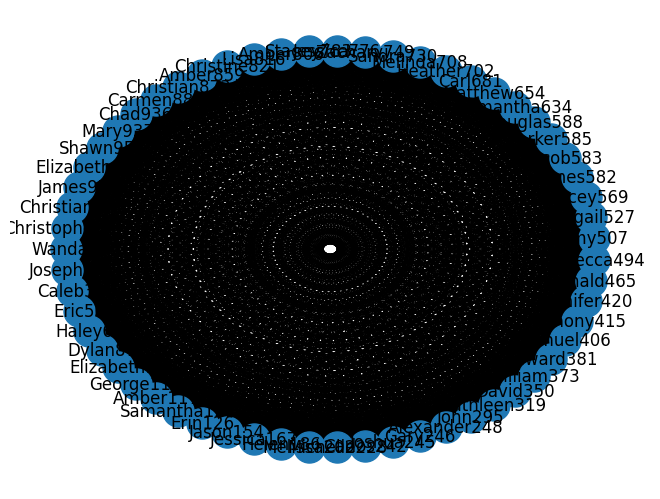

Compatibility Scores: 
Wanda9 --> Amber806: 0.9995227499682123
Common Categories: Entertainer, Software company, Government organisation, Clinic, Graphic Designer, Digital creator, Artist, Institute, Pet Store, Science and tech, Photographer
Wanda9 --> Stacey783: 0.9992859548420825
Common Categories: Entertainer, Software company, Government organisation, Musician/Band, Digital creator, Politician, Artist, Property, Institute, Pet Store, Science and tech, Photographer, Publisher
Wanda9 --> Christopher991: 0.9984944216828036
Common Categories: Science and tech, Clinic, Property, Politician, Artist
Wanda9 --> Christian976: 0.9984494387565802
Common Categories: Software company, Clinic, Property, Pet Store, Photographer
Wanda9 --> James970: 0.9980987466100729
Common Categories: Software company, Clinic, Graphic Designer, Institute, Science and tech, Photographer
Wanda9 --> Zachary749: 0.9980691474486149
Common Categories: Digital creator, Artist, Property, Institute, Politician, Graphic D

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import filter_dataset
from pyvis import network as net

# df = pd.read_csv("/random_data.csv")
user_name = input("Enter user name: ")
df1 = pd.read_csv("C:/Users/yashs/RelatorBOT/Relator_Bot/test datasets/1000_location.csv")
df = filter_dataset.filter_ds(user_name, df1)
torch.manual_seed(32)

def gcn_main():
    G = nx.Graph()
    label = {}
    likes = {}
    search = {}

    for i, (user, category) in enumerate(zip(df['first_name'], df['categories'])):
        label[i] = user  # Use index as node label
        search[user] = i
        G.add_node(i, title=user, label=user)
        likes[user] = category
        
    for u in range(len(label)):
        for v in range(len(label)):
            if u != v:
                categories1 = set(likes[label[u]].split(','))
                categories2 = set(likes[label[v]].split(','))
                common_categories = categories1.intersection(categories2)
                union_categories = categories1.union(categories2)
                similarity_score = float(len(common_categories) / len(union_categories)) * 100
                if common_categories:
                    G.add_edge(u, v, weight=similarity_score)

    if G.number_of_edges() == 0:
        print("Error: The graph has no edges.")
        return

    edges = list(G.edges())

    x = torch.randn(len(label), 16)
    print("output:", x)
    edge_index = torch.tensor(edges).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    gcn_model = GCNModel(input_dim=16, hidden_dim=32, output_dim=1)

    gcn_output = gcn_model(data)

    visualize_graph(G, label, search, gcn_output, likes)

    # return gcn_output

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x 

def visualize_graph(G, label, search, gcn_output, likes):
    pos = nx.shell_layout(G)
    nx.draw(G, pos, labels=label, with_labels=True, node_size=500)
    plt.draw()
    plt.show()
    
    user_index = search.get(user_name)
    if user_index is not None:
        get_score(G, label, user_index, gcn_output, likes)
    else:
        print("User not found.")

    nt = net.Network(notebook=True, cdn_resources='remote', height="900px", width="100%", bgcolor="#222222", font_color="white")
    nt.barnes_hut()
    nt.from_nx(G, default_node_size=100, show_edge_weights=True, edge_scaling=True)
    neighbor_map = nt.get_adj_list()
    
    for node in nt.nodes:
        neighbors = neighbor_map[node["id"]]
        neighbor_labels = "\n".join(label[i] for i in neighbors)
        node["title"] += " Neighbors: \n" + neighbor_labels
        node["value"] = len(neighbor_map[node["id"]])

    nt.prep_notebook()
    nt.show('nx.html')

def get_score(G, label, user_index, gcn_output, likes):
    user_score = {}
    user_embedding = gcn_output[user_index].detach().numpy()
    for other_user_index in range(len(label)):
        if user_index != other_user_index:
            other_user_embedding = gcn_output[other_user_index].detach().numpy()
            similarity_score = float(
                1.0 / (1.0 + np.linalg.norm(user_embedding - other_user_embedding))  # Cosine similarity
            )
            user_score[other_user_index] = similarity_score

    print("Compatibility Scores: ")
    for other_user_index, score in sorted(user_score.items(), key=lambda x: x[1], reverse=True):
        common_categories = set(likes[label[user_index]].split(',')).intersection(set(likes[label[other_user_index]].split(',')))
        print(f"{label[user_index]} --> {label[other_user_index]}: {score}\nCommon Categories: {', '.join(common_categories)}")

gcn_main()
